# Introduction

This dataset came from kaggle.com: https://www.kaggle.com/datasets/dansbecker/powerlifting-database?select=openpowerlifting.csv

The goal of this project is to do some analysis on the data and see what insights can be found. Two areas of interest for me are:
-The relationship between bodyweight and performance on the bench press, squat, and deadlift
-How much of an effect wraps have on the amount of weight that people can lift

After doing my analysis, I will create a PowerBI dashboard to visualize my findings.

# Analysis

First I will import the necessary libraries, read the CSV file into a DataFrame, and clean the data by filtering and deleting entries that have missing values.

In [55]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

df = pd.read_csv('openpowerlifting.csv')
df = df.drop(columns=['MeetID','Name','Squat4Kg','Bench4Kg','Deadlift4Kg','Place','Wilks'])
df.drop(df[df.Sex == 'F'].index, inplace=True)
divisions = ['Open Junior','Open Senior','Open','Junior','Open Men','Junior 19-23','Boys','Juniors','Open Men 35-39']
df = df[df['Division'].isin(divisions)]
classes = ['125+','140+','90+','117.5']
df.drop(df[df.WeightClassKg.isin(classes)].index, inplace=True)
df = df.dropna(how='any')
df.head()
#df.info()

,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg
23,M,Raw,32.0,Open Junior,71.94,75,154.22,115.67,183.70,453.59
24,M,Raw,20.0,Open Junior,70.67,75,163.29,111.13,204.12,478.54
28,M,Raw,22.0,Open Junior,79.65,82.5,161.03,127.01,197.31,485.35
29,M,Raw,23.0,Open Junior,80.10,82.5,190.51,120.20,231.33,542.04
30,M,Wraps,27.0,Open Junior,76.66,82.5,165.56,124.74,201.85,492.15


In [56]:
df['Sex'].count() #total number of data points remaining

21906

Next is Linear Regression to find the coefficients for the relationship between bodyweight and one rep max on the bench, squat, and deadlift.

In [57]:
model = LinearRegression()
X = df[['BodyweightKg']].values
y = df['BestBenchKg']
model.fit(X,y)
bench_coef = round(model.coef_[0],2)
print(bench_coef)
#print(type(bench_coef))

1.13


In [58]:
model_2 = LinearRegression()
X = df[['BodyweightKg']].values
y = df['BestSquatKg']
model.fit(X,y)
squat_coef = round(model.coef_[0],2)
print(squat_coef)

1.59


In [59]:
model_3 = LinearRegression()
X = df[['BodyweightKg']].values
y = df['BestDeadliftKg']
model.fit(X,y)
deadlift_coef = round(model.coef_[0],2)
print(deadlift_coef)

1.21


I am putting these coefficients into another DataFrame because I want this information on the PowerBI dashboard.

In [60]:
coefficients = pd.DataFrame(columns=['Bench','Squat','Deadlift'])
coefficients.loc[1] = [bench_coef, squat_coef, deadlift_coef]
coefficients = coefficients.round(2)
coefficients.to_excel('coefficients.xlsx', index=False)
coefficients

,Bench,Squat,Deadlift
1,1.13,1.59,1.21


In [61]:
#for powerBI
df2 = df
df2 = df2.drop(columns=['Sex','Age','Division','TotalKg'])
df2.head()
#df['Equipment'].count()

,Equipment,BodyweightKg,WeightClassKg,BestSquatKg,BestBenchKg,BestDeadliftKg
23,Raw,71.94,75,154.22,115.67,183.70
24,Raw,70.67,75,163.29,111.13,204.12
28,Raw,79.65,82.5,161.03,127.01,197.31
29,Raw,80.10,82.5,190.51,120.20,231.33
30,Wraps,76.66,82.5,165.56,124.74,201.85


Next I will create a function to query to find the average one rep max for a lift, grouped by weight class, both for those who used wraps and those who did not. This information will be stored in two seperate DataFrames and then merged into one. A third column will be added for the difference between lifts with wraps and raw lifts. Last, I will calculate the average of the third column.

I will also create a jointplot for bodyweight vs. one rep max, colored by use of equipment.

In [62]:
def compare_equipment(df, lift_name):
    raw = df.query("Equipment == 'Raw'").groupby('WeightClassKg')[f'Best{lift_name}Kg'].mean()
    wraps = df.query("Equipment == 'Wraps'").groupby('WeightClassKg')[f'Best{lift_name}Kg'].mean()
    lift = pd.merge(raw, wraps, on='WeightClassKg')
    lift[f'difference_{lift_name}'] = lift[f'Best{lift_name}Kg_y'] - lift[f'Best{lift_name}Kg_x']
    mean_diff = round(lift[f'difference_{lift_name}'].mean(), 2)
    return mean_diff, lift

In [63]:
bench_diff, bench = compare_equipment(df, 'Bench')
bench_diff

8.23

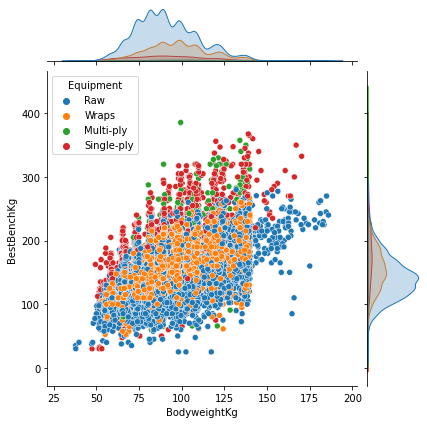

In [64]:
sns.jointplot(data=df, x = 'BodyweightKg', y = 'BestBenchKg', hue ='Equipment')

In [65]:
squat_diff, squat = compare_equipment(df, 'Squat')
squat_diff

22.99

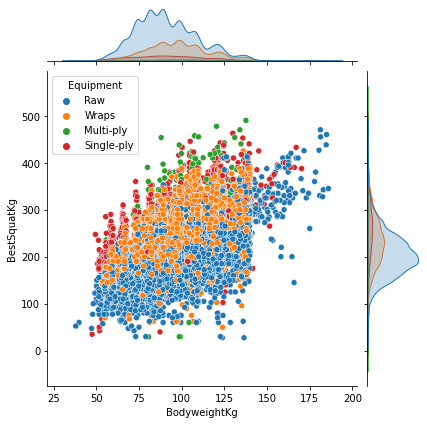

In [66]:
sns.jointplot(data=df, x = 'BodyweightKg', y = 'BestSquatKg', hue ='Equipment')

In [67]:
deadlift_diff, deadlift = compare_equipment(df, 'Deadlift')
deadlift_diff

8.87

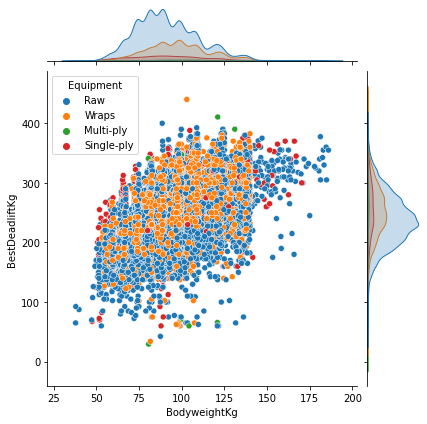

In [68]:
sns.jointplot(data=df, x = 'BodyweightKg', y = 'BestDeadliftKg', hue ='Equipment')

In [69]:
#merge bench, squat, and deadlift tables into one for use in PowerBI
df3 = pd.merge(bench,squat,on='WeightClassKg')
df3
all_lifts = pd.merge(df3,deadlift,on='WeightClassKg')
all_lifts = all_lifts.round(2)
all_lifts

,BestBenchKg_x,BestBenchKg_y,difference_Bench,BestSquatKg_x,BestSquatKg_y,difference_Squat,BestDeadliftKg_x,BestDeadliftKg_y,difference_Deadlift
WeightClassKg,,,,,,,,,
100,147.91,158.78,10.87,212.13,240.86,28.74,246.95,259.09,12.14
110,157.00,168.10,11.10,224.86,252.10,27.24,255.95,268.13,12.17
125,167.75,177.49,9.73,238.44,267.80,29.36,266.84,278.20,11.35
140,177.95,184.63,6.68,249.97,281.43,31.45,270.45,284.59,14.14
56,93.47,102.80,9.33,129.83,143.24,13.41,171.18,176.17,4.99
60,101.81,106.71,4.90,148.38,166.09,17.71,185.06,195.44,10.38
67.5,111.00,114.55,3.54,162.17,174.87,12.71,200.57,201.32,0.75
75,119.89,126.93,7.05,173.45,194.98,21.54,211.89,218.03,6.14
82.5,129.99,138.85,8.86,188.04,211.65,23.61,224.78,233.13,8.35


In [70]:
#sending dataframes to excel because PowerBI was giving me an error when I tried to have it read my python scripts
df2.to_excel('df2.xlsx', index=False)
all_lifts.to_excel('all_lifts.xlsx', index=True)

# Disclaimer

I made a PowerBI dashboard, but do not have the ability to share it since I do not have a Pro or Premium account. Instead, I will attach a PDF of the dashboard I made. The PDF shows the whole dashboard but obviously cannot use the interactive features of PowerBI. Therefore, you cannot zoom in on the scatterplot or use the filter for type of lift.

I would recommend looking at the PDF before reading my conclusion because I will be referencing to it.

https://drive.google.com/file/d/1ZHaQZP2sF5OXv3THnVUbIguV-Bb0GUDB/view?usp=share_link

# Conclusion

I knew that there would be an obvious correlation between between bodyweight and the amount of weight someone can lift. I was not really surprised to see that bodyweight is most important in the squat since the legs is the largest muscle group and the glutes are pretty big as well. What did surprise me is the coefficients from the Linear Regression. The coefficients for Bench, Squat, and Deadlift were 1.13, 1.59, and 1.21 respectively. I would have though these numbers would have been higher. I lift pretty often and would expect that if I gained 10 pounds, each of these lifts would increase by at least 20 pounds. This would correlate to coefficients of 2.0 or more. However, after thinking about it, it does make sense that these numbers are lower than I would expect based off of my own performance. All the data points in this set are from competition powerlifters, which I am not. The reason they are competing is because they are highly trained, very strong for their weight, and think that they can compete with other top-tier lifters. They are much closer to their maximum potential than I am, so it makes sense that their strength would increase at a slower rate than mine as weight is gained.

When it comes to the difference in performance between lifters using wraps and those who did not, I knew that wraps would make a significant difference. However, I did not expect the magnitude to which the difference is. Lifters using wraps averaged an extra 8.23 Kg for bench, 22.99 Kg for squat, and 8.87 Kg for deadlift. I was wondering why the number for squats is so high compared to the rest, so I found some powerlifting rules online: https://rucker.armymwr.com/application/files/6015/1248/7169/Competition_Rules_and_Guidelines.pdf

According to this website, elasticized knee sleeves may be worn as long as they are less than 8 inches in length. These types of sleeves help lifters transfer their momentum from downwards to upwards at the bottom of the lift, which is the hardest part. This is likely why the difference for the squat is so much higher than that of the bench and the deadlift.

Another thing I found very interesting was the clustering of bodyweights for the strongest lifters. After thinking about it, I think I know why this is the case. These lifters are the best of the best and they are the most competitive. They know that it is to their advantage to have their body weight as high as it can be without advancing them to the next highest weight class. This is why their bodyweights are clustered near the upper limits of each weight class and there is hardly anyone at this level who is towards the bottom or even near the middle of their weight class.